<a href="https://colab.research.google.com/github/pln-fing-udelar/embed_asoc/blob/main/Programa_Word2Vec_Multimodelo_CICADA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import re
import string
import tqdm
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Parametros
vocab_size = 65536
sequence_length = 3
ns=1
ws = 100
ep=20

In [ ]:
from google.colab import drive
# Permiso para acceder a drive desde colab
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import csv
ruta='/content/drive/My Drive/CICADA/kfold/'

filePath1 = ruta + "raw_Long.csv"
#filePath2 = ruta + "kfoldwide2.csv"
#filePath3 = ruta + "kfoldwide3.csv"
#Manzanas = pd.read_csv(filePath, sep=',',encoding="utf8",quoting=csv.QUOTE_NONE,low_memory=False)

In [ ]:
print("Leyendo data...")
text_ds1 = tf.data.TextLineDataset(filePath1).filter(lambda x: tf.cast(tf.strings.length(x), bool))
#text_ds2 = tf.data.TextLineDataset(filePath2).filter(lambda x: tf.cast(tf.strings.length(x), bool))
#text_ds3 = tf.data.TextLineDataset(filePath3).filter(lambda x: tf.cast(tf.strings.length(x), bool))

Leyendo data...


In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), ' ')

In [ ]:
print("Vectorizando...")
# Use the TextVectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(text_ds1.batch(16384))

Vectorizando...


In [ ]:
print("Creando vocabulario...")
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
#print(inverse_vocab[:20])

# Vectorize the data in text_ds.
text_vector_ds = text_ds1.batch(16384).prefetch(tf.data.AUTOTUNE).map(vectorize_layer).unbatch()

sequences = list(text_vector_ds.as_numpy_iterator())
print("Tamaño del vocab")
print(len(sequences))

Creando vocabulario...
Tamaño del vocab
698681


In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=np.random.seed(100),
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [ ]:
print("Generando Modelo")

vocab_size = 65536
sequence_length = 3
ns1=1
ws = 100
ep1=5

targets1, contexts1, labels1 = generate_training_data(
    sequences=sequences,
    window_size=ws,
    num_ns=ns1,
    vocab_size=vocab_size,
    seed=np.random.seed(1))

targets1 = np.array(targets1)
contexts1 = np.array(contexts1)[:,:,0]
labels1 = np.array(labels1)

print('\n')
print(f"targets1.shape: {targets1.shape}")
print(f"contexts1.shape: {contexts1.shape}")
print(f"labels1.shape: {labels1.shape}")



Generando Modelos


100%|██████████| 698681/698681 [05:49<00:00, 1996.88it/s]




targets1.shape: (1965278,)
contexts1.shape: (1965278, 2)
labels1.shape: (1965278, 2)
Vectorizando...
Creando vocabulario...
Tamaño del vocab
698680


100%|██████████| 698680/698680 [05:28<00:00, 2126.49it/s]




targets2.shape: (1743325,)
contexts2.shape: (1743325, 21)
labels2.shape: (1743325, 21)
Vectorizando...
Creando vocabulario...
Tamaño del vocab
698678


100%|██████████| 698678/698678 [03:55<00:00, 2967.06it/s]




targets3.shape: (1167943,)
contexts3.shape: (1167943, 6)
labels3.shape: (1167943, 6)


In [ ]:
print("Cargando data set...")

BATCH_SIZE = 16384
BUFFER_SIZE = 10000

#Modelo 1
dataset1 = tf.data.Dataset.from_tensor_slices(((targets1, contexts1), labels1))
dataset1 = dataset1.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset1 = dataset1.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Cargando data set...


In [ ]:
print("Definiendo proceso w2v...")

class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim,num):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)


Definiendo proceso w2v...


In [ ]:
print("Creando compilador...")
embedding_dim = 300

word2vec1 = Word2Vec(vocab_size, embedding_dim,ns1)
word2vec1.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

Creando compilador...


In [ ]:
print("Entrenando Modelo 1")
word2vec1.fit(dataset1, epochs=ep1, callbacks=[tensorboard_callback])

Entrenando Modelo 1
Epoch 1/5
119/119 [==============================] - 65s 533ms/step - loss: 0.6726 - accuracy: 0.6584
Epoch 2/5
119/119 [==============================] - 56s 472ms/step - loss: 0.5368 - accuracy: 0.8104
Epoch 3/5
119/119 [==============================] - 56s 471ms/step - loss: 0.4504 - accuracy: 0.8372
Epoch 4/5
119/119 [==============================] - 56s 471ms/step - loss: 0.3688 - accuracy: 0.8809
Epoch 5/5
119/119 [==============================] - 56s 475ms/step - loss: 0.2896 - accuracy: 0.9184
Entrenando Modelo 2
Epoch 1/5
106/106 [==============================] - 98s 912ms/step - loss: 3.0026 - accuracy: 0.1924
Epoch 2/5
106/106 [==============================] - 87s 819ms/step - loss: 2.7165 - accuracy: 0.2765
Epoch 3/5
 76/106 [====================>.........] - ETA: 24s - loss: 2.4611 - accuracy: 0.3537

KeyboardInterrupt: ignored

In [ ]:
weights1 = word2vec1.get_layer('w2v_embedding').get_weights()[0]
vocab1 = vectorize_layer.get_vocabulary()

In [ ]:
import pandas as pd
import numpy as np
ruta='/content/drive/My Drive/CICADA/'

filePathSimlex = ruta + "simlex.csv"
ManzanasSimLex = pd.read_csv(filePathSimlex, encoding='UTF-8')

filePathAbstract = ruta + "similarityList.abstract.es.csv"
ManzanasAbstract = pd.read_csv(filePathAbstract, encoding='UTF-8')

filePathConcrete = ruta + "similarityList.concrete.es.csv"
ManzanasConcrete = pd.read_csv(filePathConcrete, encoding='UTF-8')

lindiceSimlex1 = []
lindiceAbstract1 = []
lindiceConcrete1 = []

lindiceSimlex2 = []
lindiceAbstract2 = []
lindiceConcrete2 = []

lindiceSimlex3 = []
lindiceAbstract3 = []
lindiceConcrete3 = []
print("Generando Archivo de Similaridad...")
import sklearn.metrics.pairwise
import numpy as np
import pandas as pd
import io
n=0
#out_v = io.open('Similaridad.csv', 'w', encoding='utf-8')
for n in range(0,3321):
  #print(ManzanasSimLex['wordA'][n])
  #print(ManzanasSimLex['wordB'][n])

  indiceSimlex1 = -1
  indiceAbstract1 = -1
  indiceConcrete1 = -1
  if n<1889:
    try:
      indiceSimlex1 = sklearn.metrics.pairwise.cosine_similarity(np.array(weights1[vocab1.index(ManzanasSimLex['wordA'][n])].reshape(1,-1)),
                                                        np.array(weights1[vocab1.index(ManzanasSimLex['wordB'][n])].reshape(1,-1)))
    except Exception:
      pass
  try:
      indiceAbstract1 = sklearn.metrics.pairwise.cosine_similarity(np.array(weights1[vocab1.index(ManzanasAbstract['wordA'][n])].reshape(1,-1)),
                                                        np.array(weights1[vocab1.index(ManzanasAbstract['wordB'][n])].reshape(1,-1)))
  except Exception:
    pass

  try:
      indiceConcrete1 = sklearn.metrics.pairwise.cosine_similarity(np.array(weights1[vocab1.index(ManzanasConcrete['wordA'][n])].reshape(1,-1)),
                                                        np.array(weights1[vocab1.index(ManzanasConcrete['wordB'][n])].reshape(1,-1)))
  except Exception:
    pass

  #print(indice)
  #out_v.write(str(indice) + "\n")
  
  if n<1888:
    if indiceSimlex1==-1:
      ManzanasSimLex['rating'][n]=-1
      lindiceSimlex1.append(-1)
    else:
      lindiceSimlex1.append(indiceSimlex1)
  if indiceAbstract1==-1:
    lindiceAbstract1.append(-1)
    ManzanasAbstract['rating'][n]=-1
  else:
    lindiceAbstract1.append(indiceAbstract1)
  if indiceConcrete1==-1:
    lindiceConcrete1.append(-1)
    ManzanasConcrete['rating'][n]=-1
  else:
    lindiceConcrete1.append(indiceConcrete1)

#out_v.close()

#try:
#  from google.colab import files
#  files.download('Similaridad.csv')
#except Exception:
#  pass

Generando Archivo de Similaridad...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
from scipy import stats
rho, pval= stats.spearmanr(ManzanasSimLex['rating'], lindiceSimlex1)
rho

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:221: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asarray(a)


0.7324209636659607

In [ ]:
import math
r = rho
num = 3320
stderr = 1.0 / math.sqrt(num - 3)
delta = 1.99 * stderr
lower = math.tanh(math.atanh(r) - delta)
upper = math.tanh(math.atanh(r) + delta)
print(lower)
print(upper)

0.7159946257844464
0.7480367336465847


In [ ]:
pip install pillow

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

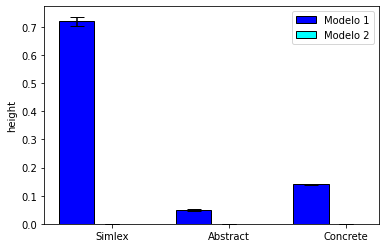

<Figure size 3600x3600 with 0 Axes>

In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
 
test = plt.figure()

# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
modelo1_bar = [0.72, 0.05, 0.14]
 
# Choose the height of the cyan bars
modelo2_bar = [0, 0, 0]
 
# Choose the height of the error bars (bars1)
yer1 = [0.0162, 0.003, 0.002]
 
# Choose the height of the error bars (bars2)
yer2 = [0, 0, 0]
 
# The x position of bars
r1 = np.arange(len(modelo1_bar))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, modelo1_bar, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Modelo 1')
 
# Create cyan bars
plt.bar(r2, modelo2_bar, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='Modelo 2')
 
# general layout
plt.xticks([r + barWidth for r in range(len(modelo1_bar))], ['Simlex', 'Abstract', 'Concrete'])
plt.ylabel('height')
plt.legend()
 
# Show graphic

#plt.plot([[1, 2, 3], [5, 2, 3]])
plt.figure(figsize=(50,50))
test.show()

test.savefig('samplefigure.png')
files.download('samplefigure.png')

In [ ]:
print("Fin del Proceso")